In [ ]:
### DDOS分析

In [1]:
!ls -lh /work/datasets/

total 13G
-rwxr-xr-x 1 hadoop hadoop 951M Apr 30 13:58 ddos_balanced.7z
-rwxr-xr-x 1 hadoop hadoop 670M Apr 30 13:58 ddos_imbalanced.7z
-rw-r--r-- 1 hadoop hadoop 6.4G Mar 24  2019 final_dataset.csv
-rw-rw-r-- 1 hadoop hadoop 5.4M Oct 28 10:12 fin.csv
-rw-rw-r-- 1 hadoop hadoop 5.3M Oct 28 10:13 t.csv
-rwxr-xr-x 1 hadoop hadoop 489M Dec 19  2011 train_triplets.txt.zip
-rw-r--r-- 1 hadoop hadoop 3.9G Mar 25  2019 unbalaced_20_80_dataset.csv
-rw-rw-r-- 1 hadoop hadoop  50M Oct  2 14:08 unbalaced_test.csv
-rwxr-xr-x 1 hadoop hadoop  24M Jul 19 14:22 yelp_academic_dataset_business.json.zip


In [1]:
# 导入处理的相关包
import pandas as pd
import numpy as np

In [2]:
# 导入文本文件，抽样了25万的文件做处理
pd.set_option('display.max_columns', None)
ddos_data=pd.read_csv('/work/DDos/unbalaced_part.csv')
ddos_data.shape

(50000, 85)

In [19]:
# 数据的规模 50000列 85 行
ddos_data.head()

,Row,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6867415,172.31.0.2-172.31.67.107-53-54063-17,172.31.67.107,54063,172.31.0.2,53,17,20/02/2018 11:32:42,763,1,1,29.0,45.0,29.0,29.0,29.00,0.000000,45.0,45.0,45.000000,0.000000,96985.58322411533,2621.231979030144,763.000000,0.000000,763.0,763.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0,0,0,0,8,8,1310.615990,1310.615990,29.0,45.0,34.333333,9.237604,85.333333,0,0,0,0,0,0,0,0,1.0,51.50,29.00,45.000000,0,0,0,0,0,0,1,29,1,45,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,866786,172.31.69.28-18.218.115.60-80-55289-6,18.218.115.60,55289,172.31.69.28,80,6,22/02/2018 12:12:02 AM,1080,1,1,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.0,1851.8518518518522,1080.000000,0.000000,1080.0,1080.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0,0,0,0,20,20,925.925926,925.925926,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,1.0,0.00,0.00,0.000000,0,0,0,0,0,0,1,0,1,0,-1,32738,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,26669,192.168.10.3-192.168.10.9-53-56344-17,192.168.10.9,56344,192.168.10.3,53,17,03/07/2017 06:13:17 PM,23630,1,3,35.0,253.0,35.0,35.0,35.00,0.000000,109.0,35.0,84.333333,42.723920,12187.896741430384,169.27634363097755,7876.666667,13636.724692,23623.0,3.0,0.0,0.0,0.000000,0.0,0.0,23630.0,11815.00,16704.690599,23627.0,3.0,0,0,0,0,8,24,42.319086,126.957258,35.0,109.0,64.600000,40.531469,1642.800000,0,0,0,0,0,0,0,0,3.0,80.75,35.00,84.333333,0,0,0,0,0,0,1,35,3,253,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,2038975,172.31.69.28-52.14.136.135-80-51451-6,172.31.69.28,80,52.14.136.135,51451,6,22/02/2018 12:26:23 AM,163188,4,3,935.0,311.0,935.0,0.0,233.75,467.500000,311.0,0.0,103.666667,179.555934,7635.36534549109,42.89531092972523,27198.000000,66241.816738,162413.0,4.0,163182.0,54394.0,93789.086673,162692.0,21.0,162694.0,81347.00,114644.636647,162413.0,281.0,0,0,0,0,92,72,24.511606,18.383705,0.0,935.0,155.750000,333.141218,110983.071429,0,1,0,0,0,0,1,1,0.0,178.00,233.75,103.666667,0,0,0,0,0,0,4,935,3,311,-1,32768,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,155024,172.31.69.28-18.218.55.126-80-62189-6,18.218.55.126,62189,172.31.69.28,80,6,21/02/2018 11:44:24 PM,11391,2,5,248.0,935.0,248.0,0.0,124.00,175.362482,935.0,0.0,187.000000,418.144712,103853.919761215,614.5202352734615,1898.500000,4261.247083,10587.0,2.0,10587.0,10587.0,0.000000,10587.0,10587.0,11391.0,2847.75,5345.340299,10858.0,2.0,0,0,0,0,40,124,175.577210,438.943025,0.0,935.0,147.875000,329.673621,108684.696429,0,1,0,0,0,0,1,1,2.0,169.00,124.00,187.000000,0,0,0,0,0,0,2,248,5,935,-1,219,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [3]:
# 标签情况
ddos_data["Label"].value_counts()

Benign    40000
ddos      10000
Name: Label, dtype: int64

In [4]:
# 暂时剔除无意义的特征
del ddos_data['Row']
# 删除非数值
other_data = ddos_data.drop([
    'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
    'Timestamp'
],
                            axis=1)

In [24]:
other_data[:1]

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,763,1,1,29.0,45.0,29.0,29.0,29.0,0.0,45.0,45.0,45.0,0.0,96985.58322411533,2621.231979030144,763.0,0.0,763.0,763.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,1310.61599,1310.61599,29.0,45.0,34.333333,9.237604,85.333333,0,0,0,0,0,0,0,0,1.0,51.5,29.0,45.0,0,0,0,0,0,0,1,29,1,45,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [45]:
data=other_data.fillna(0)

In [71]:
def max_min_sc_my(raw_data,field):
    """
    自定义函数实现最大最小值归一化处理
    """
    max_value=raw_data[field].values.max()
    min_value=raw_data[field].values.min()
    return (raw_data[field].values-min_value)/(max_value-min_value)

In [2]:
def max_min_sc(X):
    # 特征归一化处理
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(X)


def label_encoder(y):
    # 标签数值化，方便处理
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    return le.fit_transform(y)

In [3]:
def deal_nan_inf(X):
    """
    处理inf和nan
    """
    import numpy as np
    return np.nan_to_num(X)

In [4]:
# 导入处理的相关包
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)


def get_data_set(file_path):

    ddos_data = pd.read_csv(file_path)
    # 暂时剔除无意义的特征
    del ddos_data['Row']
    # 删除非数值列
    other_data = ddos_data.drop([
        'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
        'Timestamp'
    ],
                                axis=1)
    # 删除空值
    other_data = other_data.dropna(how='all')
    # 转换为numpy  aarray
    new_data = other_data.to_numpy()
    # 拆分特征列和目标列
    X, y = new_data[:, :-1], new_data[:, -1]
    # 数值型转换类型
    X = X.astype(float)
    return X, y

In [5]:
def split_X_y(X, y):
    # 拆分数据集
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=2019)
    return X_train, X_test, y_train, y_test

In [6]:
def knn_model(X_train, y_train):
    from sklearn.neighbors import KNeighborsClassifier
    # 需要全部转换为数值型
    knn = KNeighborsClassifier(n_neighbors=6,
                               weights='uniform',
                               algorithm='auto',
                               leaf_size=30,
                               p=2,
                               metric='minkowski',
                               metric_params=None,
                               n_jobs=10)
    knn.fit(X_train, y_train)
    return knn

In [30]:
def get_accuracy_score(y_test, y_pred):
    #准确率
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test, y_pred)


def get_average_precision_score(y_test, y_pred):
    # 平均准确率
    from sklearn.metrics import average_precision_score
    return average_precision_score(y_test, y_pred)


def get_confusion_matrix(y_test, y_pred):
    # 测试集混淆矩阵
    from sklearn.metrics import confusion_matrix
    return confusion_matrix(y_true=y_test, y_pred=y_pred)


def get_f1_score(y_test, y_pred):

    # F1-score
    from sklearn.metrics import classification_report
    return classification_report(y_test, y_pred)


# 0 分类的测试集
def get_y_test(X_test, y_test, label):
    X_test_label = X_test[y_test == label]
    return y_test[y_test == label], knn.predict(X_test_label)

#### 精确率
Precision=TP/(TP+FP)

#### 召回率
Recall=TP/(TP+FN)

In [36]:
con_mat[0,0]/(con_mat[0,0]+con_mat[1,1])

0.8041549011698266

In [93]:
# 获得精确率与召回率
def get_acc_recall(y_test, y_pred):
    """
    获得精确率与召回率
    """
    con_mat = get_confusion_matrix(y_test, y_pred)
    return con_mat[0, 0] / (con_mat[0, 0] + con_mat[0, 1]), con_mat[0, 0] / (
        con_mat[0, 0] + con_mat[0, 1])

In [9]:
# AOC曲线
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
sns.set_style("whitegrid")
%matplotlib inline


def get_aoc(y_test, y_pred):
    """
    y_test：实际的标签, y_pred：预测的概率值
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
    plt.plot(fpr, tpr, lw=1, label='ROC(area = %0.2f)' % (roc_auc))
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.title("Receiver Operating Characteristic, ROC(AUC = %0.2f)" %
              (roc_auc))

In [10]:
def get_roc_score(y_test, y_pred):
    """
    计算roc score
    """
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_test, y_pred)

In [94]:
def get_evaluation_index(y_test, y_pred):
    print("1.accuracy_score: %s" % get_accuracy_score(y_test, y_pred))
    print("2.average_precision_score: %s" %
          get_average_precision_score(y_test, y_pred))
    print("3.confusion_matrix:\n%s" % get_confusion_matrix(y_test, y_pred))
    print("4.acuracyc&recall: %s" % get_acc_recall(y_test, y_pred))
    print("5.F1_score:\n%s" % get_f1_score(y_test, y_pred))
    print("6.roc_auc_score: %s" % get_roc_score(y_test, y_pred))
    print("7.AUC:")
    get_aoc(y_test, y_pred)

In [25]:
def convern_tofloat32(X):
    """
    由于算法对数据集类型的不同，转换函数
    """
    dt_X=X.astype('float32')
    dt_X=np.nan_to_num(dt_X)
    return dt_X

In [16]:
def is_nan_inf(X):
    """
    判断是否有空值或者inf值
    """
    return np.isinf(X).any() or np.isnan(X).any()

In [14]:
X, y = get_data_set("/work/datasets/fin.csv")
y=label_encoder(y)
y[:10]

/work/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
X=convern_tofloat32(X)

In [27]:
dt_X_train,dt_X_test,dt_y_train,dt_y_test=split_X_y(X,y)

In [21]:
pd.DataFrame(dt_y_train)[0].value_counts()

0    8008
1    7991
Name: 0, dtype: int64

In [83]:
def dt_model(X_train,y_train):
    from sklearn.tree import DecisionTreeClassifier
    dec_tree = DecisionTreeClassifier(criterion='gini',
                                  splitter='best',
                                  max_depth=5,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=None,
                                  random_state=None,
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  min_impurity_split=None,
                                  class_weight=None,
                                  presort=False)
    dec_tree.fit(X_train,y_train)
    return dec_tree

In [28]:
%%time
# DT
dt = dt_model(dt_X_train, dt_y_train)
dt_y_pred = dt.predict(dt_X_test)
dt_y_pred

CPU times: user 190 ms, sys: 1.82 ms, total: 192 ms
Wall time: 243 ms


array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
# 保存DT tree?

1.accuracy_score: %s 0.99075
2.average_precision_score: %s 0.9852043180772201
3.confusion_matrix:
%s [[1969   23]
 [  14 1994]]
4.acuracyc&recall: %s (0.9884538152610441, 0.49684582387080495)
5.F1_score:
%s               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1992
           1       0.99      0.99      0.99      2008

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

6.roc_auc_score: %s 0.9907408518536296
7.AUC:


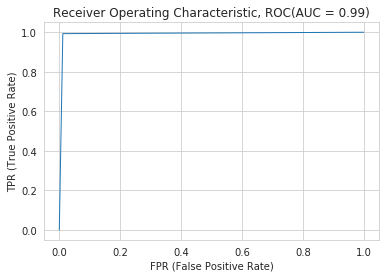

In [31]:
get_evaluation_index(dt_y_test,dt_y_pred)

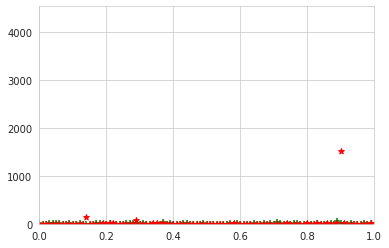

In [64]:
#设置坐标轴范围
plt.xlim((0, 1))
plt.scatter(np.arange(0,1,0.01),dt_X_test[dt_y_test==0,1][:100],color='green',marker='+')
plt.scatter(np.arange(0,1,0.01),dt_X_test[dt_y_test==1,1][:100],color='red',marker='*')

In [72]:
dt_X_test=max_min_sc_my(dt_X_test,0)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [73]:
dt_X_test[0]

array([ 1.2074359e+07,  2.0000000e+00,  1.0000000e+01,  5.4000000e+01,
        2.8360000e+03,  5.4000000e+01,  0.0000000e+00,  2.7000000e+01,
        3.8183765e+01,  5.3600000e+02,  0.0000000e+00,  2.8360001e+02,
        2.7008771e+02,  2.3935017e+02,  9.9384159e-01,  1.0976690e+06,
        2.0477239e+06,  6.9150030e+06,  1.5000000e+01,  1.5000000e+01,
        1.5000000e+01,  0.0000000e+00,  1.5000000e+01,  1.5000000e+01,
        1.2074359e+07,  1.3415955e+06,  2.2075575e+06,  6.9150030e+06,
        2.3000000e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  4.0000000e+01,  2.0400000e+02,  1.6564026e-01,
        8.2820129e-01,  0.0000000e+00,  5.3600000e+02,  2.2230769e+02,
        2.6160767e+02,  6.8438562e+04,  0.0000000e+00,  1.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  5.0000000e+00,  2.4083333e+02,
        2.7000000e+01,  2.8360001e+02,  0.0000000e+00,  0.0000000e+00,
      

In [109]:
# RF 随机森林
def rf_model(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(
        n_estimators=200,
        criterion='gini',
        max_depth=5,  # 最大深度
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_impurity_split=None,
        bootstrap=True,
        oob_score=False,
        n_jobs=30,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None)
    rf.fit(X_train, y_train)
    return rf

In [111]:
# Input contains NaN, infinity or a value too large for dtype('float32')
rf = rf_model(dt_X_train, dt_y_train)
rf_y_pred = rf.predict(dt_X_test)
rf_y_pred

array([0, 1, 1, ..., 0, 1, 1])

/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow e

1.accuracy_score: %s 0.9916
2.average_precision_score: %s 0.9443250060284543
3.confusion_matrix:
%s [[8001   19]
 [ 114 1866]]
4.acuracyc&recall: %s (0.9976309226932668, 0.8108847674065065)
5.F1_score:
%s               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8020
           1       0.99      0.94      0.97      1980

    accuracy                           0.99     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000

6.roc_auc_score: %s 0.9700275825587545
7.AUC:


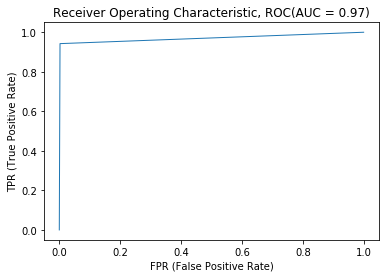

In [112]:
get_evaluation_index(dt_y_test,rf_y_pred)

In [113]:
def xgb_model(X_train, y_train):
    #XGBoot
    from sklearn.ensemble import GradientBoostingClassifier
    xgb = GradientBoostingClassifier(learning_rate=0.2,
                                     n_estimators=100,
                                     subsample=1.0,
                                     criterion='friedman_mse',
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_depth=5,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     init=None,
                                     random_state=None,
                                     max_features=None,
                                     verbose=0,
                                     max_leaf_nodes=None,
                                     warm_start=False,
                                     presort='auto',
                                     validation_fraction=0.1,
                                     n_iter_no_change=None,
                                     tol=0.0001)
    xgb.fit(X_train, y_train)
    return xgb

In [115]:
%%time
xgb =xgb_model(dt_X_train, dt_y_train)
xgb_y_pred = xgb.predict(dt_X_test)
xgb_y_pred

array([0, 1, 1, ..., 0, 1, 1])

/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow e

1.accuracy_score: %s 0.9916
2.average_precision_score: %s 0.9952467459404168
3.confusion_matrix:
%s [[8017    3]
 [   8 1972]]
4.acuracyc&recall: %s (0.9996259351620947, 0.8025828411252378)
5.F1_score:
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8020
           1       1.00      1.00      1.00      1980

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

6.roc_auc_score: %s 0.9977927655608454
7.AUC:


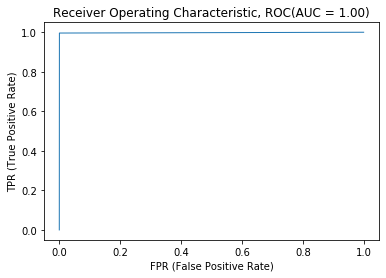

In [116]:
get_evaluation_index(dt_y_test,xgb_y_pred)

In [3]:
# 获得数据集
file_path = '/work/DDos/unbalaced_part.csv'
X,y=get_data_set(file_path)

NameError: name 'get_data_set' is not defined

In [39]:
X,y

(array([[7.6300000e+02, 1.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [1.0800000e+03, 1.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [2.3630000e+04, 1.0000000e+00, 3.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [4.3000000e+01, 2.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [1.3536010e+06, 8.0000000e+00, 7.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [8.7365598e+07, 2.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         8.7365598e+07, 8.7365598e+07]]),
 array(['Benign', 'ddos', 'Benign', ..., 'Benign', 'Benign', 'Benign'],
       dtype=object))

In [41]:
X=deal_nan_inf(X)
X

array([[7.6300000e+02, 1.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0800000e+03, 1.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.3630000e+04, 1.0000000e+00, 3.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.3000000e+01, 2.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.3536010e+06, 8.0000000e+00, 7.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.7365598e+07, 2.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.7365598e+07, 8.7365598e+07]])

In [46]:
is_nan_inf(X)

False

In [45]:
X=max_min_sc(X)
X

/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([[6.35835861e-06, 8.84689562e-06, 1.06224772e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.00003578e-06, 8.84689562e-06, 1.06224772e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.96917449e-04, 8.84689562e-06, 3.18674315e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.58334758e-07, 1.76937912e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.12800532e-02, 7.07751650e-05, 7.43573401e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.28049544e-01, 1.76937912e-05, 0.00000000e+00, ...,
        0.00000000e+00, 7.28442316e-01, 7.28442316e-01]])

In [2]:
def hmm_model(X_train, y_train):
    # HMM
    # 需要安装包 hmmlearn
    from hmmlearn import hmm
    h = hmm.GaussianHMM(n_components=5,
                        covariance_type='diag',
                        min_covar=0.001,
                        startprob_prior=1.0,
                        transmat_prior=1.0,
                        means_prior=0,
                        means_weight=0,
                        covars_prior=0.01,
                        covars_weight=1,
                        algorithm='viterbi',
                        random_state=None,
                        n_iter=10,
                        tol=0.01,
                        verbose=False,
                        params='stmc',
                        init_params='stmc')
    h.fit(X_train, y_train)
    return h

In [48]:
X=convern_tofloat32(X)
X.dtype

dtype('float32')

In [49]:
is_nan_inf(X)

False

In [50]:
X

array([[6.3583584e-06, 8.8468960e-06, 1.0622477e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.0000358e-06, 8.8468960e-06, 1.0622477e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9691745e-04, 8.8468960e-06, 3.1867431e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.5833474e-07, 1.7693792e-05, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.1280053e-02, 7.0775168e-05, 7.4357342e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.2804952e-01, 1.7693792e-05, 0.0000000e+00, ..., 0.0000000e+00,
        7.2844231e-01, 7.2844231e-01]], dtype=float32)

In [53]:
X_train, X_test, y_train, y_test = split_X_y(X, y)

In [1]:
%%time
# Input contains NaN, infinity or a value too large for dtype('float64')
hmm_m=hmm_model(X_train,y_train)

NameError: name 'hmm_model' is not defined

In [46]:
X

array([[7.630000e+02, 1.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.080000e+03, 1.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.363000e+04, 1.000000e+00, 3.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [4.300000e+01, 2.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.353601e+06, 8.000000e+00, 7.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.736560e+07, 2.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        8.736560e+07, 8.736560e+07]], dtype=float32)

In [74]:
ddos=pd.read_csv("/work/datasets/fin.csv")
ddos.head

/work/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<bound method NDFrame.head of            Row                                  Flow ID          Src IP  \
0          624     192.168.4.118-203.73.24.75-4504-80-6   192.168.4.118   
1          625     192.168.4.118-203.73.24.75-4504-80-6   192.168.4.118   
2          626     192.168.4.118-203.73.24.75-4505-80-6   192.168.4.118   
3          627     192.168.4.118-203.73.24.75-4505-80-6   192.168.4.118   
4          628     192.168.4.118-203.73.24.75-4506-80-6   192.168.4.118   
...        ...                                      ...             ...   
19994  1725894   172.31.67.50-209.85.203.113-53598-80-6  209.85.203.113   
19995  5681778   172.31.69.17-108.174.10.14-54599-443-6    172.31.69.17   
19996  6395326      172.31.0.2-172.31.65.49-53-61087-17    172.31.65.49   
19997  4926899      172.31.0.2-172.31.67.58-53-61580-17    172.31.67.58   
19998  7656685  169.254.169.254-172.31.65.89-80-49393-6    172.31.65.89   

       Src Port           Dst IP  Dst Port  Protocol               Ti

In [75]:
ddos.head()

,Row,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,624,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:32 AM,3974862,29,44,86.0,59811.0,86.0,0.0,2.965517,15.969799,1460.0,0.0,1359.340909,372.027190,15069,18.3654,55206.416667,195478.316654,1566821.0,167.0,3735347.0,133405.25,341775.688712,1805015.0,167.0,3974862.0,92438.651163,248174.820574,1566821.0,3997.0,0,0,0,0,768,896,7.295851,11.069567,0.0,1460.0,809.418919,728.862428,531240.438541,0,1,0,0,0,0,0,0,1.0,820.506849,2.965517,1359.340909,0,0,0,0,0,0,29,86,44,59811,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,625,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:36 AM,63,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,31746,63.000000,0.000000,63.0,63.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,20,20,15873.015873,15873.015873,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,1.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,-1,17520,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,626,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:36 AM,476078,2,6,86.0,3037.0,86.0,0.0,43.000000,60.811183,1460.0,0.0,506.166667,740.224403,6559.85,16.804,68011.142857,110862.707451,232203.0,6.0,134.0,134.00,0.000000,134.0,134.0,476078.0,95215.600000,123467.303580,232601.0,6.0,0,0,0,0,40,136,4.200992,12.602977,0.0,1460.0,347.000000,632.515217,400075.500000,0,1,0,0,0,0,0,0,3.0,390.375000,43.000000,506.166667,0,0,0,0,0,0,2,86,6,3037,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,627,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:37 AM,151,2,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,19867.5,75.500000,98.287843,145.0,6.0,145.0,145.00,0.000000,145.0,145.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,40,20,13245.033113,6622.516556,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,1,0,-1,17520,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,628,192.168.4.118-203.73.24.75-4506-80-6,192.168.4.118,4506,203.73.24.75,80,6,12/06/2010 08:34:37 AM,472507,2,5,73.0,1050.0,73.0,0.0,36.500000,51.618795,1050.0,0.0,210.000000,469.574275,2376.68,14.8146,78751.166667,118675.492251,232355.0,7.0,179.0,179.00,0.000000,179.0,179.0,472507.0,118126.750000,131726.857333,232875.0,7.0,0,0,0,0,40,116,4.232742,10.581854,0.0,1050.0,140.375000,368.430624,135741.125000,0,1,0,0,0,0,0,0,2.0,160.428571,36.500000,210.000000,0,0,0,0,0,0,2,73,5,1050,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [76]:
ddos["Src IP"].value_counts()

192.168.2.110     3302
192.168.56.1      1333
192.168.56.102    1162
192.168.3.114     1155
192.168.2.109     1038
                  ... 
172.217.12.166       1
52.5.76.109          1
52.84.139.169        1
202.72.201.25        1
189.47.168.151       1
Name: Src IP, Length: 1768, dtype: int64

In [77]:
ddos["Src Port"].value_counts()

443      890
445      274
0        191
80       188
3389      85
        ... 
53485      1
36977      1
61689      1
57595      1
52444      1
Name: Src Port, Length: 11152, dtype: int64

In [79]:
ddos["Dst Port"].value_counts()

80       11113
53        3399
443       1807
3389      1396
445        533
         ...  
51971        1
64261        1
51987        1
56129        1
49216        1
Name: Dst Port, Length: 1381, dtype: int64

In [80]:
ddos["Protocol"].value_counts()

6     16349
17     3459
0       191
Name: Protocol, dtype: int64

In [84]:
yy_pred =  dt.predict(X)
yy_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

1.accuracy_score: %s 0.9929496474823741
2.average_precision_score: %s 0.9878561439343261
3.confusion_matrix:
%s [[9896  104]
 [  37 9962]]
4.acuracyc&recall: %s (0.9896, 0.49833820122872396)
5.F1_score:
%s               precision    recall  f1-score   support

           0       1.00      0.99      0.99     10000
           1       0.99      1.00      0.99      9999

    accuracy                           0.99     19999
   macro avg       0.99      0.99      0.99     19999
weighted avg       0.99      0.99      0.99     19999

6.roc_auc_score: %s 0.9929498149814981
7.AUC:


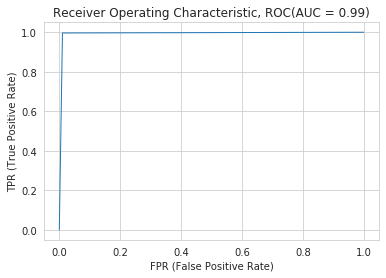

In [85]:
get_evaluation_index(y,yy_pred)

In [88]:
# 随机打乱标志

y[np.random.randint(0,len(y),100)]

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0])

In [90]:
from sklearn.tree import DecisionTreeClassifier
# entropy
dt_entropy = DecisionTreeClassifier(criterion='entropy',
                                  splitter='best',
                                  max_depth=5,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=None,
                                  random_state=None,
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  min_impurity_split=None,
                                  class_weight=None,
                                  presort=False)

In [91]:
%%time
dt_entropy.fit(dt_X_train, dt_y_train)
y_pred_e = dt_entropy.predict(dt_X_test)
y_pred_e[:10]

CPU times: user 4.13 s, sys: 0 ns, total: 4.13 s
Wall time: 4.22 s


array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

1.accuracy_score: %s 0.9935
2.average_precision_score: %s 0.989373183851894
3.confusion_matrix:
%s [[1975   17]
 [   9 1999]]
4.acuracyc&recall: %s (0.9914658634538153, 0.4969803724207348)
5.F1_score:
%s               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1992
           1       0.99      1.00      0.99      2008

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

6.roc_auc_score: %s 0.993491895870334
7.AUC:


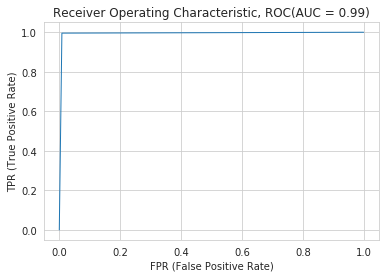

In [92]:
get_evaluation_index(dt_y_test,y_pred_e)

In [95]:
from sklearn.metrics import recall_score
recall_score(dt_y_test,y_pred_e)

0.9955179282868526

In [96]:
1975/(1975+9)

0.9954637096774194